## DSCI 100 Group Project 

By Tony Fu, Hao Jiang, and Aimee Garcia Castro

## Introduction: 

There are many elements that play a role in how well a student will perform on a test. The objective for this group project is predicting the knowledge level of an individual based on such elements. The knowledge levels include: `high`, `middle`, `low` and `very_low` We will be looking at the "User Knowledge" dataset obtained from the UCI Machine Learning Repository. The data in this dataset looks at `STG` (the degree of study time for goal object materials), `SCG` (the degree of repetition number of user for goal object materials), `STR` (the degree of study time of user for related objects with goal object), `LPR` (the exam performance of user for related object with goal object), and `PEG` (the exam performance of user for goal objects). As well, it relates `PEG` to `UNS` (the knowledge level of the user). This data will be used as predictors for `UNS`
 
Our predictive question that we will try to answer is: “Can we predict the `UNS` of an individual based on factors such as `STG`, `SCG`, and `STR`?”

## Tidying the Data: 

We begin by loading the libraries required to perform exploratory analysis. 

In [2]:
library(tidyverse)
library(ggplot2)
library(tidymodels)
library(repr)
library(GGally)
library(readxl)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Now, we need to transfer the data from the website to R, since the data is located on the website. As the data is available as an Excel spreadsheet, we are going to need to download it as a file with `download.file`. We have stored the file described as an url from the Internet as an object called `url`.

After we have downloaded the data as a file on R, we are going to use the `read_excel` function to transfer the data from the spreadsheet. We will use `sheet = 2` as the second sheet is listed as **training data**, which would be crucial once we created our classifier.

We notice that the last 3 columns are irrelevant to the data, so we will be selecting the wanted data with the `select` function.

Furthermore, although not required, we chose to lowercase all the `UNS` labels to keep the labeling consistent with the `mutate` function, along with the `recode` function.

In [3]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"

download.file(url, destfile = "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls")

user_knowledge <- read_excel(path = "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", sheet = 2) %>%
    select(STG:UNS) %>%
    mutate(UNS = recode(UNS, High = 'high', Middle = 'middle', Low = 'low'))

user_knowledge

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,high
0.06,0.06,0.05,0.25,0.33,low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,high
0.50,0.75,0.81,0.61,0.26,middle
0.66,0.90,0.76,0.87,0.74,high


*Table 1*: Tidied "User Knowledge" data set obtained from UCI Machine Learning Repository

## Searching for NAs:


We will now be looking for NA values in our data set, and handle them appropriately as they represent a missing value in our data. 

In [4]:
sum(is.na(user_knowledge))

[1] 0

Thankfully there are no NAs in our data frame, so no further adjustments must be made to our current data set.

## Defining Variables:

We have already mentioned what each of the variables acronym means in the introduction. However, to reiterate, `STG` represents the study time for main topics, `SCG` represents the reptition in studying, `STR` represents study time for related topics, `LPR` represents exam performance of related topics, `PEG` represents exam performance of main topics, and `UNS` represents the knowledge level. All variables from `STG` to `PEG` have a range from 0 to 1. `UNS` contain the labels `very_low`, `low`, `middle`, and `high`, where `very_low` corresponds to a much lower knowledge leve whereas `high` corresponds to a higher knowledge level.

## Determining Predictors:

To begin, we have decided to remove `LPR` since a high `LPR` would result from a high `STR`. If we include both as predictors, we would essentially be using the same predictor `STR` twice. This leads to `STR` having a larger influence than wanted. We have also decided to remove `PEG` since `UNS` is based on `PEG`, meaning `PEG` will have a larger influence than other possible predictors.

In [5]:
user_knowledge <- user_knowledge %>%
    select(-LPR, -PEG)

user_knowledge

STG,SCG,STR,UNS
<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,very_low
0.08,0.08,0.10,high
0.06,0.06,0.05,low
⋮,⋮,⋮,⋮
0.54,0.82,0.71,high
0.50,0.75,0.81,middle
0.66,0.90,0.76,high


*Table 2*: Potential predictors that may be used for analysis

Now, we are left with four variables: `STG`, `SCG`, `STR`, and `UNS`. Since the categorical class we are trying to predict `UNS`, we must turn it into a factor. This is done by using the `mutate` and `as_factor` functions.

In [6]:
user_knowledge <- user_knowledge %>%
    mutate(UNS = as.factor(UNS))

user_knowledge

STG,SCG,STR,UNS
<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,very_low
0.08,0.08,0.10,high
0.06,0.06,0.05,low
⋮,⋮,⋮,⋮
0.54,0.82,0.71,high
0.50,0.75,0.81,middle
0.66,0.90,0.76,high


*Table 3*: Potential predictors with `UNS` changed to class "factor"

Currently, we need to see which predictors we should use and which ones should be removed. We will do this through a method called forward selection, where we are building a model by adding one predictor at a time. This model will select the most accurate combinations given the predictors STG, SCG, and STR. We have also used the `set.seed` function to make sure our findings for accuracy are reproducible. 

*Note: The following code was taken from Chapter 6.8 of the textbook.*

In [7]:
set.seed(1)

names <- colnames(user_knowledge %>% select(-UNS)) 
example_formula <- paste("UNS", "~", paste(names, collapse="+"))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

user_knowledge_vfold <- vfold_cv(user_knowledge, v = 5, strata = UNS)

n_total <- length(names)

selected <- c()

for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names[[j]])
        model_string <- paste("UNS", "~", paste(preds_new, collapse="+"))

        user_knowledge_recipe <- recipe(as.formula(model_string), 
                                data = user_knowledge) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())
        
        acc <- workflow() %>%
          add_recipe(user_knowledge_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = user_knowledge_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,UNS ~ STG,0.5001508
2,UNS ~ STG+STR,0.4033183
3,UNS ~ STG+STR+SCG,0.3917044


*Table 4*: Accuracies of different number of predictors used in the model

As we can see in the table, the most accurate predictor is `STG`. The second most would be `STR`, since the model selected `STG` and `STR` as the most accurate combination when using two predictors. Finally, `SCG` would be the least accurate predictor out of the three. We also notice that there is a constant decrease when we add predictors. We tried removing `STG` from the data set to have the model measure the accuracy of the combination of `STR` and `SCG`. We did the same to measure the accuracy of the combination of `STG` and `SCG`. We found that the original combination of `STG` and `STR` resulted in the highest accuracy of the combination of two predictors, which means we will them in our analysis as we require at least two predictors to create a visualization. Thus, we can remove `SCG` from our data frame.

In [8]:
user_knowledge <- user_knowledge %>%
    select(-SCG)

user_knowledge

STG,STR,UNS
<dbl>,<dbl>,<fct>
0.00,0.00,very_low
0.08,0.10,high
0.06,0.05,low
⋮,⋮,⋮
0.54,0.71,high
0.50,0.81,middle
0.66,0.76,high


*Table 5*: Predictors that will be used for analysis

## Exploratory Analysis:

To start, we will perform some exploratory analysis on our predictors `STG` and `STR` and see their relationship with our categorial variable of interest `UNS`. Since `UNS` has different levels, we will create boxplots showing the relationship between `STG` and `STR`, and each level of `UNS`. We will be reordering the boxplots in terms of ascending order of means.

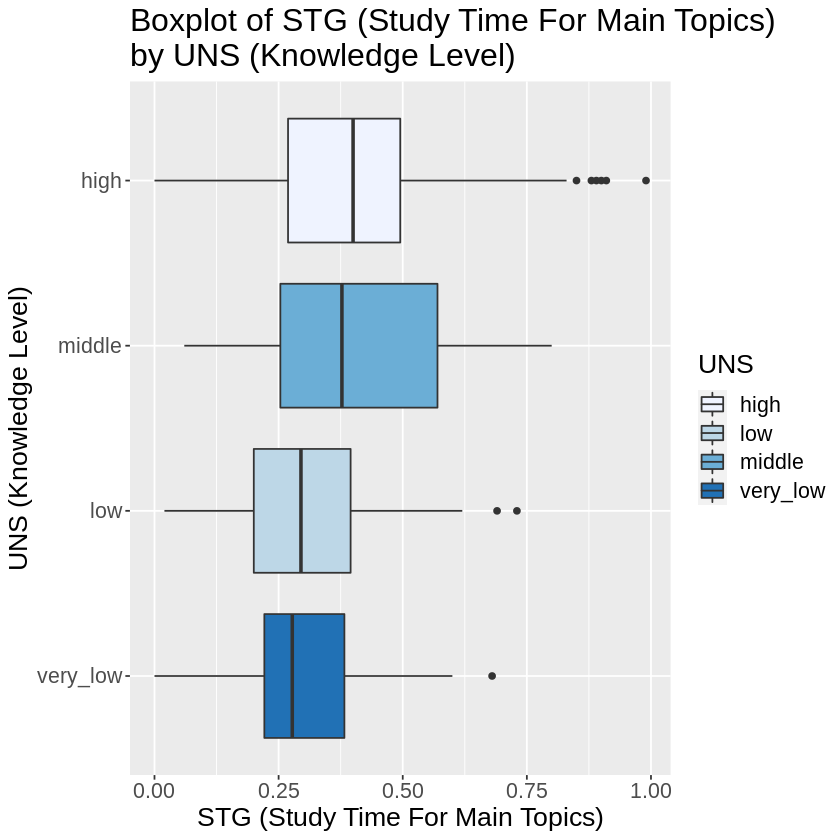

In [9]:
user_knowledge_plot <- ggplot(user_knowledge, aes(x = STG, y = reorder(UNS, +STG), fill = UNS)) +
    geom_boxplot() +
    labs(x = "STG (Study Time For Main Topics)", y = "UNS (Knowledge Level)") +
    ggtitle("Boxplot of STG (Study Time For Main Topics) \nby UNS (Knowledge Level)") + 
    scale_fill_brewer(palette="Blues") +
    theme(text = element_text(size = 16)) 

user_knowledge_plot

*Figure 1*: Boxplot of `STG` per `UNS`

Looking at Figure 1, we can see that the mean for `very_low` has the lowest `STG` while the mean for `high` has the highest `STG`. We can conclude that as `STG` increases, so does the `UNS` as seen with the means of each boxplot. This indicates that there is a positive relationship between `STG` and the different levels of `UNS` based on the means. Although, the relationship is incredibly weak as the means do not differ greatly. Hence, `STG` does affect the levels of `UNS`, but not greatly. This will be discussed in our data analysis section.

We can make similar boxplots showing the relationship between `STR` and each level of `UNS`.

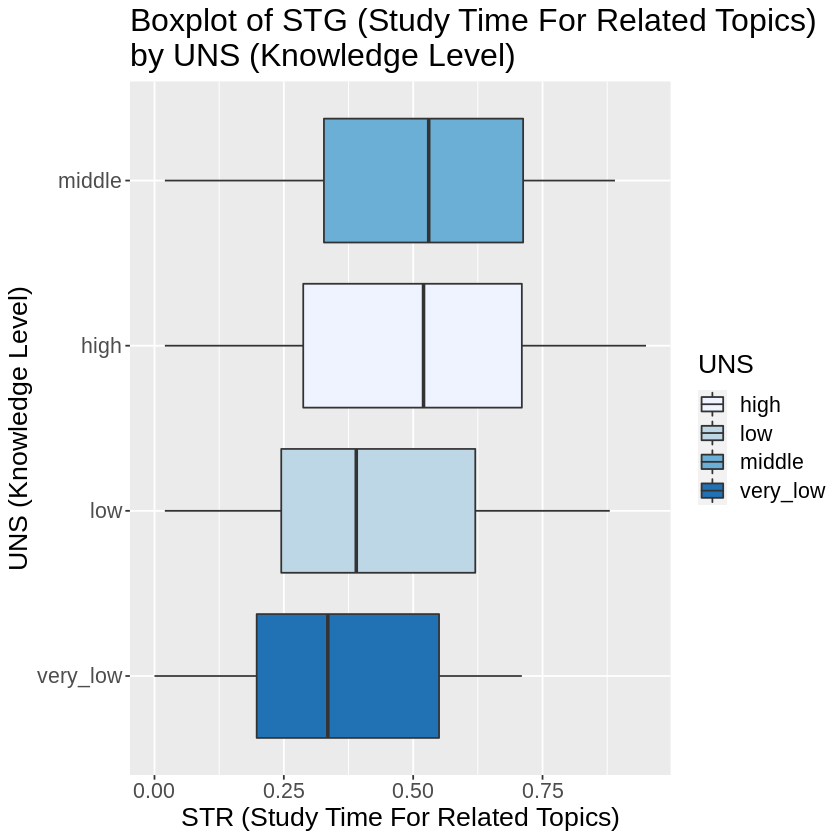

In [10]:
user_knowledge_plot_2 <- ggplot(user_knowledge, aes(x = STR, y = reorder(UNS, +STR), fill = UNS)) +
    geom_boxplot() +
    labs(x = "STR (Study Time For Related Topics)", y = "UNS (Knowledge Level)") +
    ggtitle("Boxplot of STG (Study Time For Related Topics) \nby UNS (Knowledge Level)") + 
    scale_fill_brewer(palette="Blues") +
    theme(text = element_text(size = 16)) 

user_knowledge_plot_2

*Figure 2*: Boxplot of `STR` per `UNS`

Looking at *Figure 2*, we can see that `very_low` and `low` have the lowest and second lowest `STR` means respectively. However, `middle` has a STR mean that is slightly larger than `high`. Therefore, we can say there is a positive relationship between `STR` and the different levels of `UNS` based on the means till it gets to `middle`. After that, there is no relationship. Moreover, from `very_low` to `middle`, there is a stronger relationship when compared to the strength of the relationship between `STR` and the levels of `UNS`. Thus, we can say `STR` does impact `UNS` from `very_low` to `middle` substantially, but it does not have a great impact between `middle` and `high`. This will be talked about in the data analysis section.

## Summarizing the Data Set

Now, we will summarize the data set to obtain statistics which will be used for the data analysis section.  

First, we start by calculating the mean, median, and standard deviation of both `STG` and `STR` in the data set.

In [11]:
stg_stats <- user_knowledge %>%
    summarize(mean_stg = mean(STG),
              med_stg = median(STG), 
              sd_stg = sd(STG))

stg_stats

mean_stg,med_stg,sd_stg
<dbl>,<dbl>,<dbl>
0.3711473,0.327,0.2102712


*Table 7*: Mean, median, and standard deviation of `STG`

Here, the `STG` mean is around 0.37. The `STG` median is around 0.33, and the standard deviation is around 0.21.

In [12]:
str_stats <- user_knowledge %>%
    summarize(mean_stg = mean(STR),
              med_stg = median(STR), 
              sd_stg = sd(STR))

str_stats

mean_stg,med_stg,sd_stg
<dbl>,<dbl>,<dbl>
0.4680039,0.49,0.2459398


*Table 8*: Mean, median, and standard deviation of `STR`

On the other hand, the `STR` mean is around 0.47. The `STR` median is 0.49, and the standard deviation is around 0.25.

Next, we found the number and percentage of the levels of `UNS` in our data set with the `group_by` and `summarize` functions. This will let see if one label is more frequent compared to others.

In [13]:
UNS_proportions <- user_knowledge %>%
    group_by(UNS) %>%
    summarize(n = n()) %>%
    mutate(percent = 100 * n / nrow(user_knowledge))

UNS_proportions

`summarise()` ungrouping output (override with `.groups` argument)



UNS,n,percent
<fct>,<int>,<dbl>
high,63,24.418605
low,83,32.170543
middle,88,34.108527
very_low,24,9.302326


*Table 9*: Proportions of each UNS level 

For our training data, we have 63 (24%) highs, 88 (34%) middles, 83 (32%) lows and 24 (9%) very lows in our data set regarding levels of `UNS`. We can see that there are more `middle` and `low` labels compared to `high` labels, and much more compared to `very low` labels.

We can also find the range of STG and STR in our data set.

In [14]:
stg_range <- range(user_knowledge$STG)

stg_range

[1] 0.00 0.99

The lowest `STG` value observed is 0 and the largest observed is 0.99.

In [15]:
str_range <- range(user_knowledge$STR)

str_range

[1] 0.00 0.95

The lowest `STR` value observed is 0 while the largest observed is 0.95.

## Building the Classifier

Firstly, we need to create a recipe to preprocess our unscaled data. By doing so, our predictors will be scaled and centered.

In [16]:
set.seed(1)

user_knowledge_recipe <- recipe(UNS ~ STG + STR, data = user_knowledge) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

user_knowledge_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Now, we will try to find the optimal value of K to use in our classifier. We will perform a 10-fold cross-validation on our training data. We use the `vfold_cv` function along with the data set, the number of folds (v), and the strata arguments. The strata argument contains our categorical variable `UNS`.  

In [17]:
set.seed(1)

user_knowledge_vfold <- vfold_cv(user_knowledge, v = 10, strata = UNS)
print(user_knowledge_vfold)

#  10-fold cross-validation using stratification 
# A tibble: 10 x 2
   splits           id    
   <list>           <chr> 
 1 <split [231/27]> Fold01
 2 <split [231/27]> Fold02
 3 <split [231/27]> Fold03
 4 <split [232/26]> Fold04
 5 <split [232/26]> Fold05
 6 <split [233/25]> Fold06
 7 <split [233/25]> Fold07
 8 <split [233/25]> Fold08
 9 <split [233/25]> Fold09
10 <split [233/25]> Fold10


Now, we will build our tune model. Since we want to do a classification, we will specify the engineer as `kknn` and the mode as `classification`. We will also use `tune()` in the neighbors argument since we have not yet chosen a K value. 

In [18]:
set.seed(1)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Below, we make the k_vals data frame with the neighbors variable containing values from 1 to 100 (stepping by 5). Then we make our workflow containing the recipe and the model and we pass the k_vals data frame to the grid argument of tune_grid function. Finally, we use the collect_metrics function to add the mean and standard error of the classifier’s validation accuracy and we filter from the .metrics column to see the accuracy.

In [19]:
set.seed(1)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

user_knowledge_results <- workflow() %>%
    add_recipe(user_knowledge_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = user_knowledge_vfold, grid = k_vals) %>%
    collect_metrics()%>% 
    filter(.metric == "accuracy") 

user_knowledge_results

! Fold04: internal: No observations were detected in `truth` for level(s): 'very_l...

! Fold05: internal: No observations were detected in `truth` for level(s): 'very_l...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3446154,10,0.03265097,Model01
6,accuracy,multiclass,0.4268148,10,0.02330864,Model02
11,accuracy,multiclass,0.4060684,10,0.02477198,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,accuracy,multiclass,0.3834188,10,0.02239125,Model18
91,accuracy,multiclass,0.3832764,10,0.01999835,Model19
96,accuracy,multiclass,0.3680228,10,0.02242504,Model20


*Table 10*: Results from 10-fold cross validation

In order to choose the best number of neighbors we create a line graph using the user_knowledge_results dataset with neighbors on the x-axis and the mean on the y-axis.

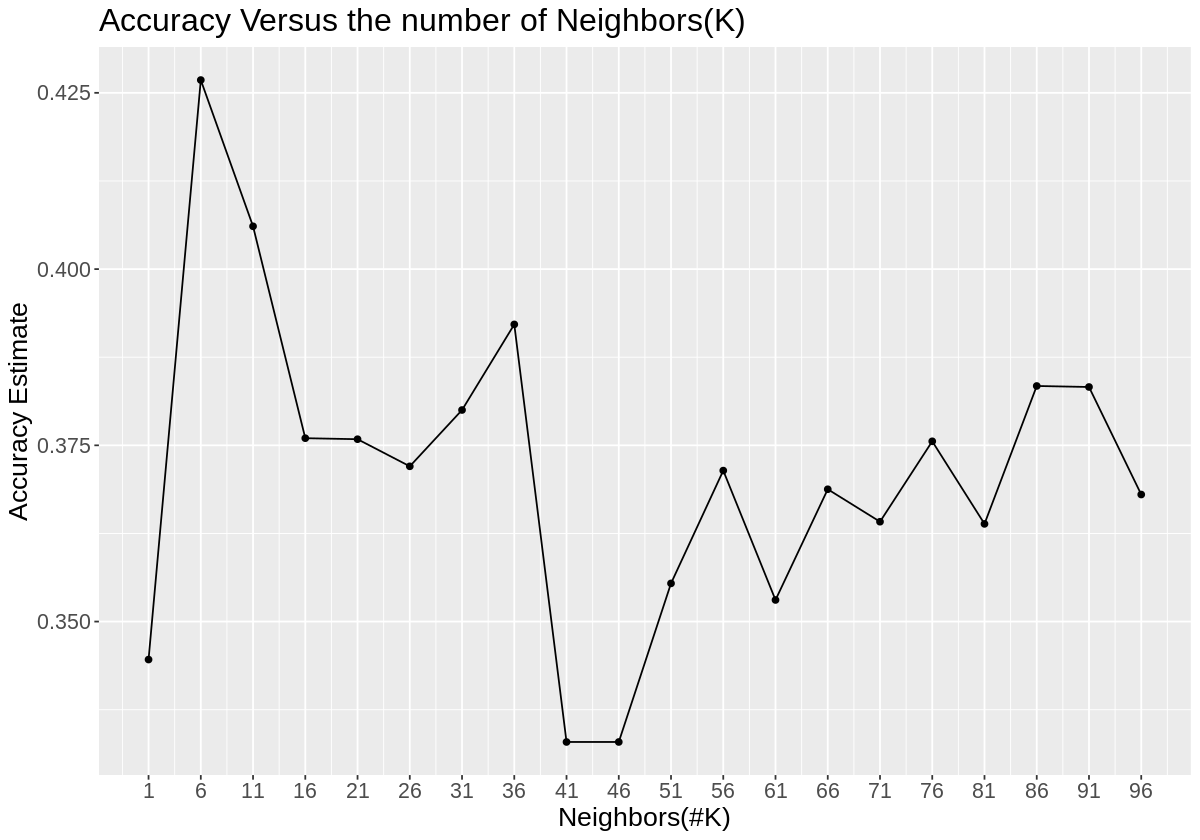

In [20]:
set.seed(1)

options(repr.plot.width = 10, repr.plot.height = 7)

accuracy_versus_k <- ggplot(user_knowledge_results, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors(#K)", y = "Accuracy Estimate") +
    ggtitle("Accuracy Versus the number of Neighbors(K)") +
    theme(text = element_text(size = 16)) +
    scale_x_continuous(breaks = seq(1, 96, by = 5))

accuracy_versus_k

*Figure 3*: Plot of accuracy estimate vs neighbors

We take the K with the highest accuracy estimate to use in the classifier. In this case, any value between 6 to 11 would be acceptable as they are the highest in the graph. We have decided to use K = 7 as our K value should be an odd number to avoid ties. It is has one of the highest accuracy estimate out of all the points and it is a low K value. We will remake our model using K = 7.

In [21]:
set.seed(1)

knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) %>%
          set_engine("kknn") %>%
          set_mode("classification")

knn_spec_2

user_knowledge_fit <- workflow() %>%
                      add_recipe(user_knowledge_recipe) %>%
                      add_model(knn_spec_2) %>%
                      fit(data = user_knowledge)

user_knowledge_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 7
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~7, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.6317829
Best kernel: rectangular
Best k: 7

To evaluate the estimated accuracy of our classifier on the test set, we use the `predict` and `bind_cols` functions. We can compare the .pred_class column (which contains the predictions from our classifier) with the `UNS` column (which contains the true values).

In [22]:
set.seed(1)

user_knowledge_test <- read_excel(path = "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", sheet = 3) %>%
    select(STG, STR, UNS) %>%
    mutate(UNS = gsub(" ", "", UNS)) %>%
    mutate(UNS = recode(UNS, High = "high", Middle = "middle", Low = "low", VeryLow = "very_low")) %>%
    mutate(UNS = as.factor(UNS))

user_knowledge_test_predictions <- predict(user_knowledge_fit, user_knowledge_test) %>%
                                   bind_cols(user_knowledge_test)

user_knowledge_test_predictions

New names:
* `` -> ...7
* `` -> ...8



.pred_class,STG,STR,UNS
<fct>,<dbl>,<dbl>,<fct>
low,0.00,0.50,very_low
low,0.05,0.55,low
low,0.08,0.63,high
⋮,⋮,⋮,⋮
middle,0.56,0.77,low
middle,0.66,0.81,middle
middle,0.68,0.79,middle


*Table 11*: Testing data with our classifier's prediction added

Finally, to get statistics about the quality of our model, we use the metrics function and we filter by .metrics to see the accuracy.

In [23]:
set.seed(1)

user_knowledge_prediction_accuracy <- user_knowledge_test_predictions %>%
                metrics(truth = UNS, estimate = .pred_class) %>%
                filter(.metric == "accuracy")

user_knowledge_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.3793103


*Table 12*: The metrics of classifier's predictions on the testing data

Looking at the value of the .estimate variable shows that the estimated accuracy of the classifier on the test data is around 39%.

Also, by using the conf_mat function we looked at the confusion matrix in order to see the table of predicted labels and correct labels.

In [24]:
set.seed(1)

user_knowledge_mat <- user_knowledge_test_predictions %>% 
      conf_mat(truth = UNS, estimate = .pred_class)

user_knowledge_mat

          Truth
Prediction high low middle very_low
  high       10   4      7        3
  low        10  26      9       15
  middle     19  16     18        7
  very_low    0   0      0        1

*Table 13*: Confusion matrix that shows correct and incorrect predictions

Our classifier predicted `high` correctly 10 times and incorrectly 29 times. It predicted `middle` correctly 18 times and incorrectly 16 times. It predicted `low` correctly 26 times and incorrectly 20 times. It also predicted `very_low` correctly 1 time and incorrectly 25 times.

To test some made-up observations, we will create some tibbles and predict their `UNS` with our classifier. The first tibble we have created represents an average student, using the mean STG and STR value we calculated in the "Summarizing the Data Set" section.

In [25]:
first_observation <- tibble(STG = 0.37, STR = 0.47)

first_prediction <- predict(user_knowledge_fit, first_observation)

first_prediction

.pred_class
<fct>
low


The classifier predicted that this observation would be labelled as `low`. This is interesting as we would expect an average student would be predicted as either a `low` or `middle` level, which would be considered as an average level. 

We will do another test observation of a student in the 90th percentile. We will use 90% of the largest STG and STR that we found in the "Summarizing the Data Set" section. 

In [26]:
second_observation <- tibble(STG = 0.9 * 0.99, STR = 0.9 * 0.95)

second_prediction <- predict(user_knowledge_fit, second_observation)

second_prediction

.pred_class
<fct>
middle


The classifier predicted that this observation would also be labelled as `middle`. In this case, `high` would be a more appropriate prediction as a student in the 90th percentile probably has a higher level of knowledge.

Now, we will be visualizing our data by creating a graph, which has `STG` on the x-axis, `STR` on the y-axis, and colors each point based on `UNS`.

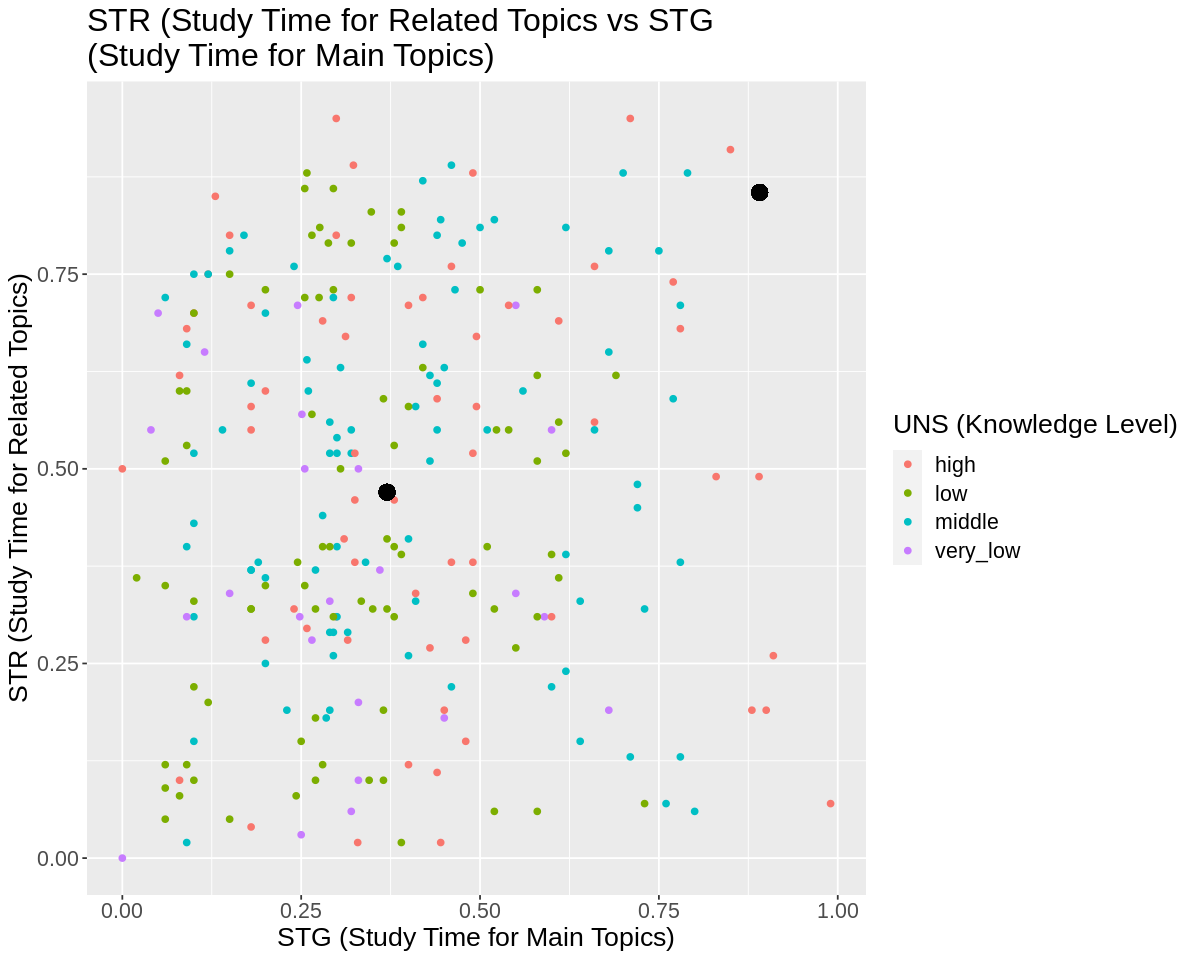

In [27]:
options(repr.plot.width = 10, repr.plot.height = 8)

user_knowledge_graph <- user_knowledge %>%
    ggplot(aes(x = STG, y = STR, color = UNS)) + 
    geom_point() + 
    labs(x = "STG (Study Time for Main Topics)", y = "STR (Study Time for Related Topics)", color = "UNS (Knowledge Level)") +
    ggtitle("STR (Study Time for Related Topics vs STG \n(Study Time for Main Topics)") + 
    theme(text = element_text(size = 16)) +
    geom_point(aes(x = 0.37, y = 0.47), color = "black", size = 4) + 
    geom_point(aes(x = 0.9 * 0.99, y = 0.9 * 0.95), color = "black", size = 4) 
    

user_knowledge_graph

*Figure 4*: Plot of `STR` vs `STG` colored by `UNS` with the additional two created observations

## Data Analysis and Discussion

Finally, we can create another graph visualizing our predictions to see if there are any interesting patterns.

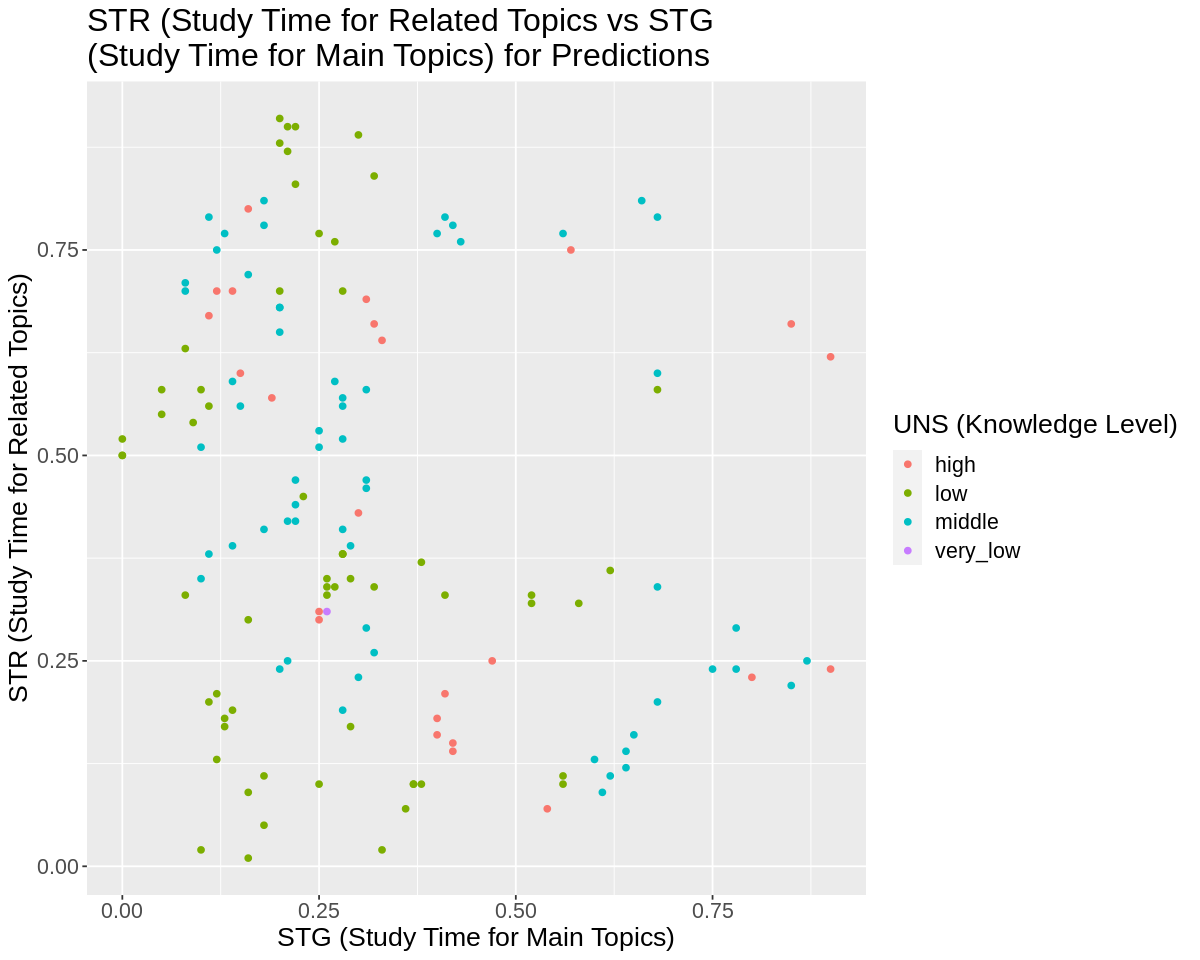

In [28]:
options(repr.plot.width = 10, repr.plot.height = 8)

predictions_graph <- user_knowledge_test_predictions %>%
    ggplot(aes(x = STG, y = STR, color = .pred_class)) +
    geom_point() +
    labs(x = "STG (Study Time for Main Topics)", y = "STR (Study Time for Related Topics)", color = "UNS (Knowledge Level)") +
    ggtitle("STR (Study Time for Related Topics vs STG \n(Study Time for Main Topics) for Predictions") +
    theme(text = element_text(size = 16)) 

predictions_graph

*Figure 5*: Plot of `STR` vs `STG` colored by `UNS` based on predictions